In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers,regularizers,optimizers
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import logging
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd


/home/korhan/miniconda3/envs/thesis_v2_torch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/korhan/miniconda3/envs/thesis_v2_torch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/korhan/miniconda3/envs/thesis_v2_torch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/korhan/min

In [2]:
epochs, batch_size = 20, 30
X_valid=None
Y_valid=None
nq = 30
X_train = np.float32(np.random.randn(nq,18) > .5)
Y_train = np.random.rand(nq,1) * 70

In [ ]:
#i will fit 1 time then check if reg works

In [85]:
class BidderNN(nn.Module):
    def __init__(self, M, model_parameters):
        super(BidderNN, self).__init__()

        self.model_parameters = model_parameters
        self.M = M
        
        architecture = self.model_parameters['architecture']
        dropout = self.model_parameters['dropout']
        dp = self.model_parameters['dropout_prob']

        architecture = [int(layer) for layer in architecture]  # integer check
        number_of_hidden_layers = len(architecture)
        dropout = bool(dropout)
        # -------------------------------------------------- NN Architecture -------------------------------------------------#
        # GET MODEL HERE
        # first hidden layer
        model = nn.Sequential()
        model.add_module('dense_0',nn.Linear(self.M, architecture[0])) 
        model.add_module('relu_0',nn.ReLU())
        if dropout is True: 
            model.add_module("dropout_0", nn.Dropout(p=dp))

        # remaining hidden layer
        for k in range(1, number_of_hidden_layers):
            model.add_module(f"dense_{k}", nn.Linear(architecture[k-1], architecture[k]))
            model.add_module(f"relu_{k}", nn.ReLU())
            if dropout is True:
                model.add_module(f"dropout{k}", nn.Dropout(p=dp))
        # final output layer
        model.add_module(f"dense_{k+1}_last", nn.Linear(architecture[k], 1))
        model.add_module(f"relu_{k+1}_last", nn.ReLU())        
        
        for m in model.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight,gain=1)
#                 nn.init.kaiming_uniform_(m.weight)
                m.bias.data.fill_(0.0)        

        self.model = model

    
    def forward(self, x):
        
        return self.model(x)

    
class MLCA_NN:

    def __init__(self, X_train, Y_train, scaler=None):
        self.M = X_train.shape[1]  # number of items
        self.X_train = X_train  # training set of bundles
        self.Y_train = Y_train  # bidder's values for the bundels in X_train
        self.X_valid = None   # test/validation set of bundles
        self.Y_valid = None  # bidder's values for the bundels in X_valid
        self.model_parameters = None  # neural network parameters
        self.model = None  # keras model, i.e., the neural network
        self.scaler = scaler  # the scaler used for initially scaling the Y_train values
        self.history = None  # return value of the model.fit() method from keras
        self.loss = None  # return value of the model.fit() method from keras
        self.device = torch.device('cpu') # default, may be changed in init

        
    def initialize_model(self, model_parameters):
        
        self.model_parameters = model_parameters
        # self.device = torch.device(model_parameters['device'])
        self.model = BidderNN(self.M, model_parameters).to(self.device)
        lr = model_parameters['learning_rate']
                
        # ADAM = adaptive moment estimation a first-order gradient-based optimization algorithm
        self.optimizer = optim.Adam(self.model.parameters(),lr=lr, betas=(0.9, 0.999), 
                                    weight_decay=0.0, amsgrad=False)
        self.criterion = nn.L1Loss(reduction='mean')
        logging.debug('Neural Net initialized')


    def __get_reg_loss(self, model):
        regularization_type = self.model_parameters['regularization_type']
        r = self.model_parameters['regularization']
        w1, w2 = 0,0
        # set regularization
        if regularization_type == 'l2' or regularization_type is None:
            w2 = r
        if regularization_type == 'l1':
            w1 = r
        if regularization_type == 'l1_l2':
            w1,w2 = r, r
        
        l1_regularization, l2_regularization = torch.FloatTensor([0]).to(self.device), torch.FloatTensor([0]).to(self.device)
                
        for name, param in model.named_parameters():
            if 'last' in name: continue
            l1_regularization += torch.sum( torch.abs(param) )
            l2_regularization += torch.sum( torch.square(param) )
        
        return w1*l1_regularization + w2*l2_regularization
        
        
    def fit(self, epochs, batch_size, X_valid=None, Y_valid=None):
        # set test set if desired
        self.X_valid = X_valid
        self.Y_valid = Y_valid

        size = self.X_train.shape[0]
        N_iter = size//batch_size + int(bool(size%batch_size))

        X = torch.FloatTensor(self.X_train).to(self.device)
        Y = torch.FloatTensor(self.Y_train).to(self.device)

        self.epoch_losses = {'train':[], 'val':[] ,'reg':[]}

        for n in range(epochs):

            self.model.train()
            losses = {'train':[], 'val':[] ,'reg':[]}
            nsamples = 0
            indices = np.arange(len(X)) 
            np.random.shuffle(indices)

            for i in range(N_iter):
                x = X[indices[i*batch_size: (i+1)*batch_size]]
                y = Y[indices[i*batch_size: (i+1)*batch_size]]
                nsamples += len(x)
                self.optimizer.zero_grad()
                # Compute prediction and loss
                pred = self.model(x)
                mse_loss = self.criterion(pred.flatten(), y)
                reg_loss = self.__get_reg_loss(self.model)
                loss = mse_loss + reg_loss
                
                # Backpropagation
                loss.backward()
                self.optimizer.step()
                losses['train'].append(loss.item())
                losses['reg'].append(reg_loss.item())

            self.epoch_losses['train'].append(np.mean(losses['train']))
            self.epoch_losses['reg'].append(np.mean(losses['reg'])/self.model_parameters['regularization'])
            
            if (self.X_valid is not None) and (self.Y_valid is not None):
                self.model.eval()
                Xval = torch.FloatTensor(self.X_valid).to(self.device)
                Yval = torch.FloatTensor(self.Y_valid).to(self.device)

                size_val = self.X_valid.shape[0]
                N_iter_val = size_val//batch_size + int(bool(size_val%batch_size))

                with torch.no_grad():
                    for i in range(N_iter_val):
                        x = Xval[i*batch_size: (i+1)*batch_size]
                        y = Yval[i*batch_size: (i+1)*batch_size]
                        pred = self.model(x)
                        mse_loss = self.criterion(pred.squeeze(), y)
                        reg_loss = self.__get_reg_loss(self.model)
                        loss = mse_loss + reg_loss
                        losses['val'].append(loss.item())

                epoch_losses['val'].append(np.mean(losses['val']))

            
#             loss = self.loss_info(batch_size, plot=False)
#         return (loss)
        tr, val = None, None
        # TO DO: val icin de en son loss'un varligini kontrol edip sadece onu cekecek
        tr_orig, val_orig = self.epoch_losses['train'][-1], self.epoch_losses['val']
        return ((tr, val, tr_orig, val_orig))


In [107]:
regularization_N = 1e-5
learning_rate_N = 0.01
layer_N = [32,150,50]
dropout_N = True
dropout_prob_N = 0.05
epochs, batch_size = 30, 30
regularization_type = 'l1_l2'
## type: (default,xavier,kaiming)
# nn_type = 'default'


model_parameters =  OrderedDict([('regularization', regularization_N),
                                ('learning_rate', learning_rate_N),
                                ('architecture', layer_N),
                                ('dropout', dropout_N),
                                ('dropout_prob', dropout_prob_N),
                                ('epochs', epochs),
                                ('batch_size', batch_size),
                                ('regularization_type',regularization_type),
                                ('device','cpu')])

mlca_nn_default = MLCA_NN(X_train, Y_train)
mlca_nn_default.initialize_model(model_parameters)

In [81]:
# mlca_nn.model.state_dict().keys()
# mlca_nn.model.cpu().model[0]
# mlca_nn.model.modules


(32, 18) (32,)
(150, 32) (150,)
(50, 150) (50,)
(1, 50) (1,)


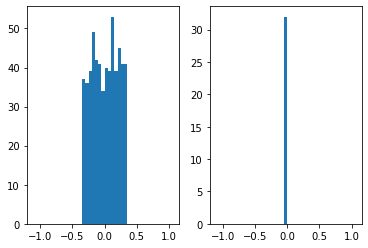

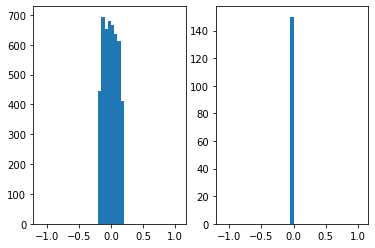

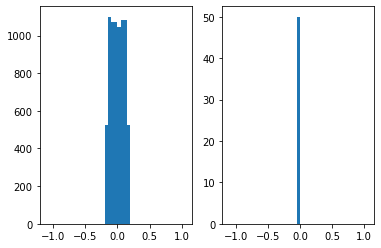

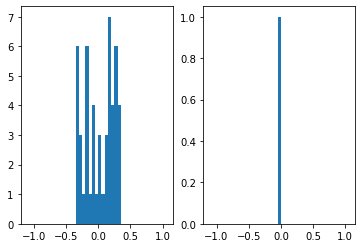

In [108]:
# DEFAULT TORCH - before training-1e-5 reg
W = []
B = []
for m in mlca_nn_default.model.modules():
    if type(m) == nn.Linear:
        W.append(m.weight.data.numpy())
        B.append(m.bias.data.numpy())        
        print(W[-1].shape, B[-1].shape)
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1.1,1.1,0.05))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1.1,1.1,0.05))

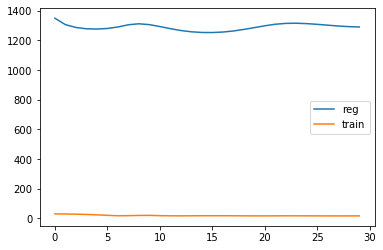

In [109]:
#fitting
losses = mlca_nn_default.fit(epochs=epochs, batch_size=batch_size)
losses
plt.plot(mlca_nn_default.epoch_losses['reg'],label='reg')
plt.plot(mlca_nn_default.epoch_losses['train'] , label='train')
plt.legend()


(32, 18) (32,)
(150, 32) (150,)
(50, 150) (50,)
(1, 50) (1,)


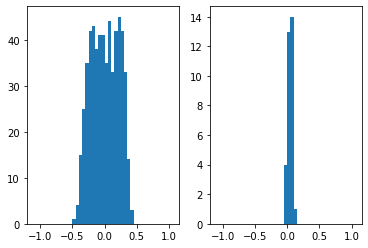

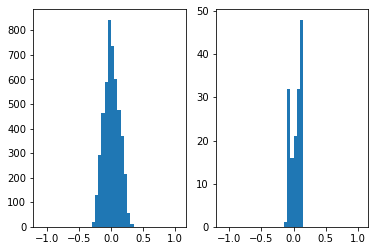

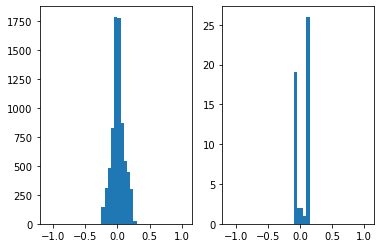

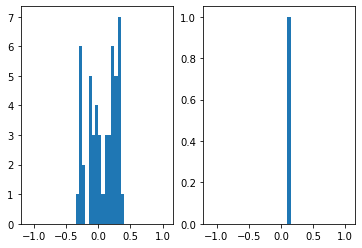

In [110]:
#after training-default 1e-5 reg
W = []
B = []
for m in mlca_nn_default.model.modules():
    if type(m) == nn.Linear:
        W.append(m.weight.data.numpy())
        B.append(m.bias.data.numpy())        
        print(W[-1].shape, B[-1].shape)
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1.1,1.1,0.05))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1.1,1.1,0.05))

In [111]:
##KERAS##

In [112]:
from tensorflow.keras import models,layers,regularizers,optimizers
# how to get weights from keras

r = regularization_N
lr = learning_rate_N
architecture = layer_N
dropout = dropout_N
dp = dropout_prob_N
regularization_type = 'l1_l2'
M = 18
architecture = [int(layer) for layer in architecture]  # integer check
number_of_hidden_layers = len(architecture)
dropout = bool(dropout)

# define input layer
inputs = layers.Input(shape=(X_train.shape[1], ))
# set regularization
REG = regularizers.l1(r)
# first hidden layer
x = layers.Dense(architecture[0], kernel_regularizer=REG, bias_regularizer=REG, activation='relu')(inputs)
if dropout is True:
    x = layers.Dropout(rate=dp)(x)
# remaining hidden layer
for k in range(1, number_of_hidden_layers):
    x = layers.Dense(architecture[k], kernel_regularizer=REG, bias_regularizer=REG, activation='relu')(x)
    if dropout is True:
        x = layers.Dropout(rate=dp)(x)
# final output layer
predictions = layers.Dense(1, activation='relu')(x)
model = models.Model(inputs=inputs, outputs=predictions)

In [113]:
model.summary()
ADAM = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
# compile the model and define the loss function
model.compile(optimizer=ADAM, loss='mean_absolute_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 18)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                608       
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 150)               4950      
_________________________________________________________________
dropout_16 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                7550      
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
__________

(18, 32) 0.34528595
(32,) 0.0
(32, 150) 0.18149623
(150,) 0.0
(150, 50) 0.173184
(50,) 0.0
(50, 1) 0.33713308
(1,) 0.0


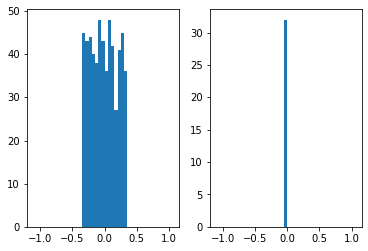

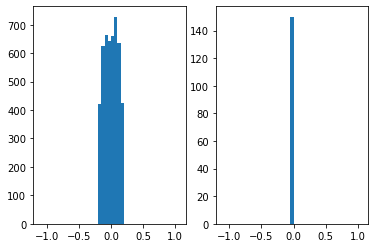

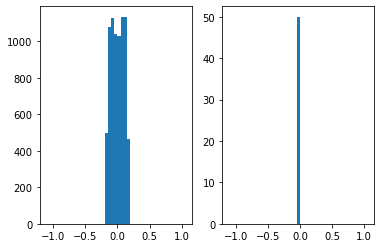

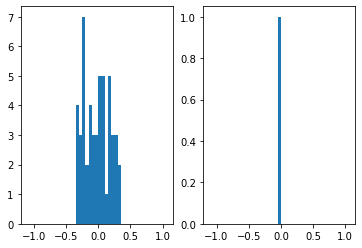

In [114]:
# DEFAULT KERAS
W = []
B = []
for i,w in enumerate(model.get_weights()):
    if i%2==0:
        W.append(w)
        
    else:
        B.append(w)
    print(w.shape, np.max(w))
    
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1.1,1.1,0.05))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1.1,1.1,0.05))

In [115]:
history = model.fit(x=X_train, y=Y_train, verbose=1, 
          epochs=epochs, batch_size=batch_size)

Epoch 1/30
30/30 [==============================] - 0s 16ms/sample - loss: 29.7870
Epoch 2/30
30/30 [==============================] - 0s 50us/sample - loss: 29.0296
Epoch 3/30
30/30 [==============================] - 0s 45us/sample - loss: 28.0822
Epoch 4/30
30/30 [==============================] - 0s 43us/sample - loss: 26.8352
Epoch 5/30
30/30 [==============================] - 0s 45us/sample - loss: 24.8172
Epoch 6/30
30/30 [==============================] - 0s 50us/sample - loss: 21.8226
Epoch 7/30
30/30 [==============================] - 0s 48us/sample - loss: 18.0978
Epoch 8/30
30/30 [==============================] - 0s 43us/sample - loss: 16.6112
Epoch 9/30
30/30 [==============================] - 0s 42us/sample - loss: 17.5990
Epoch 10/30
30/30 [==============================] - 0s 43us/sample - loss: 18.3525
Epoch 11/30
30/30 [==============================] - 0s 42us/sample - loss: 16.5964
Epoch 12/30
30/30 [==============================] - 0s 41us/sample - loss: 15.6546
E

(18, 32) 0.52964777
(32,) 0.17824166
(32, 150) 0.41676724
(150,) 0.13187887
(150, 50) 0.38133484
(50,) 0.12999013
(50, 1) 0.38621852
(1,) 0.13268314


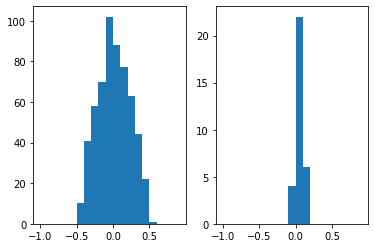

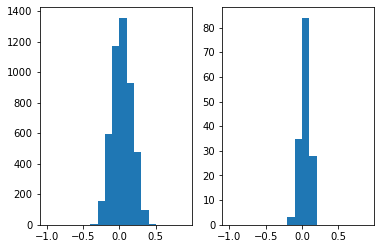

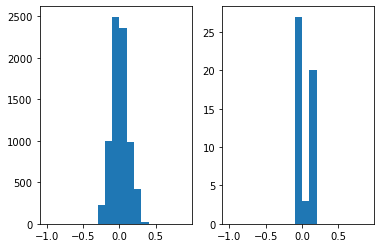

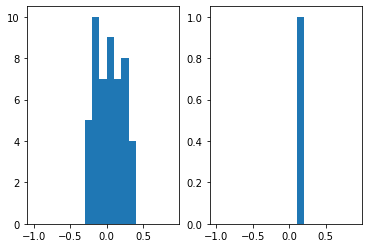

In [116]:
# DEFAULT KERAS - AFTER TRAIN
W = []
B = []
for i,w in enumerate(model.get_weights()):
    if i%2==0:
        W.append(w)
        
    else:
        B.append(w)
    print(w.shape, np.max(w))
    
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1,1,0.1))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1,1,0.1))

In [ ]:
for i,m in enumerate(nnmodel.modules()):
    print(i,m)
    

In [ ]:
for m in nnmodel.modules():
# def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        m.bias.data.fill_(0.0)
        

In [ ]:
y_true = np.random.randint(0, 2, size=(2, 3))
y_pred = np.random.random(size=(2, 3))


In [ ]:
np.mean(np.abs(y_true - y_pred), axis=-1)

In [ ]:
for m in nnmodel.parameters():
    print(m.grad)

In [ ]:
layer_type=['dense', 'input']
Layer_shapes = []
for i, (name, param) in enumerate(nnmodel.named_parameters()):
    if (i==0) and ('input' in layer_type): 
        Layer_shapes.append(param.shape[1])
    if any([x in name for x in layer_type]) and ('bias' in name):
        Layer_shapes.append(param.shape[0])
        
Layer_shapes

In [ ]:
for name, param in nnmodel.named_parameters():
#     if 'last' not in name:
    print(name)

In [ ]:
[param.data.shape[0] for name, param in nnmodel.named_parameters() 
 if (any([x in name for x in layer_type])) and ('bias' not in name)]

In [ ]:
name.split('.')

In [ ]:
for W in kerasmodel.get_weights(): print(W.shape)

In [ ]:
W

In [ ]:
18*16+16*16+16*16+16

In [ ]:
weights = []
for params in nnmodel.parameters():
    weights.append(params.detach().cpu().numpy().T)   

In [ ]:
w

In [ ]:
# UPPER BOUND TORCH
L = 5000
upper_bounds_z = []
for layer in Layer_shapes:
#     print(layer.output.shape)
    upper_bounds_z.append(np.array([L]*layer).reshape(-1, 1))
#     print(upper_bounds_z[-1].shape)
    
# upper_bounds_z

In [ ]:
upper_bounds_z

In [ ]:
kerasmodel = model

In [ ]:
# def _get_model_layers(self, key, layer_type=None):
layer_type=['dense', 'input']
Layers = kerasmodel.layers
if layer_type is not None:
    tmp = [layer.get_config()['name'] for layer in Layers]
    Layers = [Layers[i] for i in [tmp.index(s) for s in tmp if any([x in s for x in layer_type])]]
Layers

In [ ]:
# UPPER BOUND KERAS
L = 5000
upper_bounds_z = []
for layer in Layers:
    print(layer.output.shape)
    upper_bounds_z.append(np.array([L]*layer.output.shape[1]).reshape(-1, 1))
#     print(upper_bounds_z[-1].shape)
    
# upper_bounds_z

In [ ]:
weights = []
for params in mlca_nn.model.parameters():
    weights.append(params.detach().cpu().numpy().T)

In [ ]:
weights

In [ ]:
for w in weights:
    print(w.shape)

In [ ]:
history = model.fit(x=X_train, y=Y_train, verbose=1, 
          epochs=epochs, batch_size=batch_size)

In [ ]:
history.history

In [ ]:
kerasmodel = model

In [ ]:
for w in model.get_weights():
    print(w.shape)

In [ ]:
mlca_nn.model[0].weight.data.T.numpy().shape[0]

In [ ]:
Layers = kerasmodel.layers
[layer.get_config()['name'] for layer in Layers]

In [ ]:
layer.output.shape[1]

In [ ]:
upper_bounds_z

In [ ]:
tmp = [layer.get_config()['name'] for layer in Layers]
Layers = [Layers[i] for i in [tmp.index(s) for s in tmp if any([x in s for x in layer_type])]]

In [ ]:
nn.init.calculate_gain('relu')
criterion = nn.L1Loss(reduction='mean')
x ,y = torch.FloatTensor([[1,5],[2,5]]), torch.FloatTensor([[8,2],[5,3]])

criterion(x, y)
torch.abs(x - y).mean()